In [1]:
import pandas as pd
import re
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, RepeatVector, TimeDistributed, Add, Embedding, Dense, Activation, ZeroPadding1D, LSTM, SimpleRNN, BatchNormalization, Flatten, Conv1D,Bidirectional, AveragePooling1D, MaxPooling1D, GlobalMaxPooling2D,MaxPool2D, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers


In [2]:
# pip install -U tensorflow

# !pip install -U tensorflow-addons

Load the data into the environment

In [3]:
fluoride_tweets = pd.read_csv("Fluride tweets.csv")
vaccine_tweets = pd.read_csv("Vaccine tweets.csv")


Convert -1,0,1 into positive, neutral, and negative lable

In [4]:
S = []
for i in range(len(fluoride_tweets)):
  if fluoride_tweets["Sentiment"][i] == 1:
    sentiment = "positive"
  elif fluoride_tweets["Sentiment"][i] == 0:
    sentiment = "neutral"
  elif fluoride_tweets["Sentiment"][i] == -1:
    sentiment = "negative"
  else:
    sentiment = "neutral"
  S.append(sentiment)

fluoride_tweets["sentiment"] =  S

S = []
for i in range(len(vaccine_tweets)):
  if vaccine_tweets["Sentiment"][i] == 1:
    sentiment = "positive"
  elif vaccine_tweets["Sentiment"][i] == 0:
    sentiment = "neutral"
  elif vaccine_tweets["Sentiment"][i] == -1:
    sentiment = "negative"
  else:
    sentiment = "neutral"
  S.append(sentiment)

vaccine_tweets["sentiment"] =  S

In [5]:
fluoride_tweets.head(2)

,Unnamed: 0,Username,Datetime,Tweet Id,Text,Sentiment,sentiment
0,0,Financi43129186,2020-06-29 23:48:36+00:00,1.277750e+18,@DoctorKarl do you have any thoughts on the fl...,0.0,neutral
1,1,greenbenali,2020-06-29 23:41:03+00:00,1.277750e+18,@DrSextonGreen @martin_farley @TomPashby @TheG...,0.0,neutral


In [6]:
vaccine_tweets.head(2)

,Unnamed: 0,Username,Datetime,Tweet Id,Text,Sentiment,sentiment
0,0,Jidgettewynn,2020-12-29 23:59:01+00:00,1.344070e+18,@ashishkjha @SpoxHHS On top of which if we rep...,-1.0,negative
1,1,RampKingdom,2020-12-29 23:51:03+00:00,1.344070e+18,They should put @ChickfilA in charge of vaccin...,0.0,neutral


In [7]:
vaccine_tweets["selected_text"] = vaccine_tweets["Text"]
fluoride_tweets["selected_text"] = fluoride_tweets["Text"]


Combine the two datasets

In [8]:
data1 = vaccine_tweets[['selected_text','sentiment']]
data2 = fluoride_tweets[['selected_text','sentiment']]
data3= data1.append(data2)


Check the sentiment distribution

Total Vaccine related tweets: 820
           selected_text
sentiment               
negative             229
neutral              372
positive             219


Text(0.5, 1.0, 'Tweets with keyword - Covid-19 vaccine ')

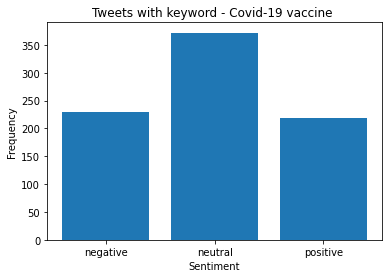

In [9]:
print("Total Vaccine related tweets:", len(data1))
#Vaccination
print(data1.groupby("sentiment").nunique())
vaccine_df = pd.DataFrame(data1.groupby("sentiment").nunique())
vaccine_df = vaccine_df.reset_index()
plt.bar(vaccine_df["sentiment"], vaccine_df["selected_text"])
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Tweets with keyword - Covid-19 vaccine ")

Total fluride related tweets: 804
           selected_text
sentiment               
negative             315
neutral              398
positive              81


Text(0.5, 1.0, 'Tweets with keyword - Fluoride OR Flurides OR Fluridation ')

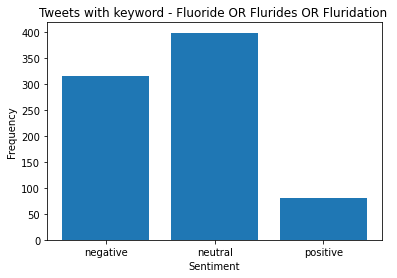

In [10]:
print("Total fluride related tweets:", len(data2))
#Fluridation
print(data2.groupby("sentiment").nunique())

fluride_df = pd.DataFrame(data2.groupby("sentiment").nunique())
fluride_df = fluride_df.reset_index()
plt.bar(fluride_df["sentiment"], fluride_df["selected_text"])
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Tweets with keyword - Fluoride OR Flurides OR Fluridation ")

Sentiment distribution overall

           selected_text
sentiment               
negative             544
neutral              770
positive             300


Text(0.5, 1.0, 'Tweets with keyword - both fluride and covid vaccine')

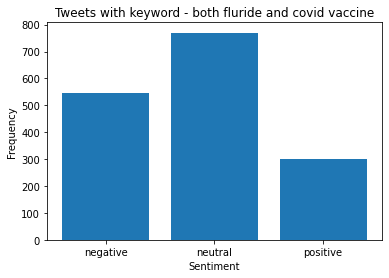

In [11]:
data3.groupby("sentiment").nunique()

print(data3.groupby("sentiment").nunique())

overall_df = pd.DataFrame(data3.groupby("sentiment").nunique())
overall_df = overall_df.reset_index()
plt.bar(overall_df["sentiment"], overall_df["selected_text"])
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Tweets with keyword - both fluride and covid vaccine")

Data cleaning

In [12]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [13]:
#Check null and repace NA 
data3["selected_text"].isnull().sum()
#Fill the only null value.
data3["selected_text"].fillna("No content", inplace = True)

In [14]:
temp = []
#Splitting pd.Series to list
data_to_list = data3['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
print(list(temp[:5]))


['On top of which if we repeat polio at 53% vaccination of total population, as the last experiment in mass vaccination, means that we will spend the next 20-40 YEARS vaccinating the next generation to get *Covid 19 under control*. Did I get that right?', 'They should put in charge of vaccination, bcz if they do it as fast as they do their drive thru we‚Äôll be out of this by March...', 'Democrats want mandatory vaccinations and require that certificates of vaccination be issued. Why not issue a Voter ID card at the same time? Oh...wait, democrats know Voter ID will prevent cheating so they‚Äôll pass on that. ', '#Covid19 Millionaire POTUS-ELECT BIDEN will immediately vaccinate 200 millon people +? Mr Biden fought for the CDC to work the distribution &amp; vaccination plans. Mr Trump had offered another distribution but acceded.', '\uf8ffüë®\uf8ffüèø\uf8ffü§≥\uf8ffüèøBe crazy if you could administer the vaccination to those already infected with the virus and, I dont know, have it heal

In [15]:
#Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)  


In [16]:
#Tokenize
data_words_train = list(sent_to_words(temp))
print(data_words_train[:10])

# DeTokenize 
data_train = []
for i in range(len(data_words_train)):
    data_train.append(detokenize(data_words_train[i]))
print(data_train[:5])


[['on', 'top', 'of', 'which', 'if', 'we', 'repeat', 'polio', 'at', 'vaccination', 'of', 'total', 'population', 'as', 'the', 'last', 'experiment', 'in', 'mass', 'vaccination', 'means', 'that', 'we', 'will', 'spend', 'the', 'next', 'years', 'vaccinating', 'the', 'next', 'generation', 'to', 'get', 'covid', 'under', 'control', 'did', 'get', 'that', 'right'], ['they', 'should', 'put', 'in', 'charge', 'of', 'vaccination', 'bcz', 'if', 'they', 'do', 'it', 'as', 'fast', 'as', 'they', 'do', 'their', 'drive', 'thru', 'we', 'aoll', 'be', 'out', 'of', 'this', 'by', 'march'], ['democrats', 'want', 'mandatory', 'vaccinations', 'and', 'require', 'that', 'certificates', 'of', 'vaccination', 'be', 'issued', 'why', 'not', 'issue', 'voter', 'id', 'card', 'at', 'the', 'same', 'time', 'oh', 'wait', 'democrats', 'know', 'voter', 'id', 'will', 'prevent', 'cheating', 'so', 'they', 'aoll', 'pass', 'on', 'that'], ['covid', 'millionaire', 'potus', 'elect', 'biden', 'will', 'immediately', 'vaccinate', 'millon', '

In [17]:
data_train = np.array(data_train)
(data_train.shape)

(1624,)

Label encoding

In [18]:
labels = np.array(data3['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral': y.append(0)
    if labels[i] == 'negative': y.append(1)
    if labels[i] == 'positive': y.append(2)
    if labels[i] == 'NA': y.append(0)
y = np.array(y)
labels_train = tf.keras.utils.to_categorical(y, 3, dtype="float32")

del y


In [19]:
X = data_train
Y = labels_train


In [20]:
X.shape, Y.shape

((1624,), (1624, 3))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


In [22]:
from keras.preprocessing.text import Tokenizer
# vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(
    # num_words = vocab_size, 
    oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [23]:
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100

padding_type='post'
truncation_type='post'

from keras.preprocessing.sequence import pad_sequences

X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=truncation_type)

X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=truncation_type)

In [24]:
len(word_index)

6477

GLOVE embedding

In [25]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-04-27 08:10:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-27 08:10:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-27 08:10:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [26]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [27]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [29]:
len(word_index)

6477

In [30]:
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

Simple RNN

Without GLOVE 

In [ ]:
# 
max_length = 100
model = Sequential([
    layers.Embedding(len(word_index), 40, input_length=max_length, 
                    embeddings_regularizer=keras.regularizers.l2(.001)),
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),

    SimpleRNN(200, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    # SimpleRNN(100, return_sequences=True),

    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])

# model.summary()

model.compile(
    keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)

Epoch 1/5
42/42 [==============================] - 6s 127ms/step - loss: 1.2273 - accuracy: 0.4026 - val_loss: 1.1296 - val_accuracy: 0.3401
Epoch 2/5
42/42 [==============================] - 5s 112ms/step - loss: 1.0928 - accuracy: 0.4513 - val_loss: 1.1929 - val_accuracy: 0.4694
Epoch 3/5
42/42 [==============================] - 4s 106ms/step - loss: 1.1009 - accuracy: 0.4650 - val_loss: 1.0872 - val_accuracy: 0.4966
Epoch 4/5
42/42 [==============================] - 4s 106ms/step - loss: 1.0430 - accuracy: 0.4985 - val_loss: 1.0524 - val_accuracy: 0.4898
Epoch 5/5
42/42 [==============================] - 5s 109ms/step - loss: 0.9960 - accuracy: 0.5274 - val_loss: 1.1140 - val_accuracy: 0.4898


In [ ]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 9ms/step - loss: 1.1788 - accuracy: 0.4601


[1.1787856817245483, 0.4601227045059204]

With Glove

In [ ]:
# SimpleRNN(15)

In [ ]:
# 
model = Sequential([
    embedding_layer,
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),

    SimpleRNN(200, dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])

model.summary()

model.compile(
    keras.optimizers.Adam(0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

unit_history = model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          647800    
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 100, 200)          60200     
                                                                 
 flatten_12 (Flatten)        (None, 20000)             0         
                                                                 
 dense_25 (Dense)            (None, 70)                1400070   
                                                                 
 dense_26 (Dense)            (None, 3)                 213       
                                                                 
Total params: 2,108,283
Trainable params: 1,460,483
Non-trainable params: 647,800
_________________________________________________________________
Epoch 1/5
42/42 [====================

In [ ]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 9ms/step - loss: 3.7063 - accuracy: 0.3926


[3.7063324451446533, 0.39263802766799927]

LSTM

Without Glove

In [78]:
max_length = 100
model = Sequential([    
    layers.Embedding(len(word_index), 40, input_length=max_length, 
                    embeddings_regularizer=keras.regularizers.l2(.001)),
    LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True), 
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    # LSTM(32,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])

model.summary()

model.compile(
    keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 40)           259080    
                                                                 
 lstm_12 (LSTM)              (None, 100, 64)           26880     
                                                                 
 flatten_28 (Flatten)        (None, 6400)              0         
                                                                 
 dense_59 (Dense)            (None, 70)                448070    
                                                                 
 dense_60 (Dense)            (None, 3)                 213       
                                                                 
Total params: 734,243
Trainable params: 734,243
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
37/37 [==============================

In [79]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 27ms/step - loss: 1.1785 - accuracy: 0.5767


[1.1784660816192627, 0.5766870975494385]

With Glove

In [80]:

model = Sequential([
    embedding_layer,
    LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True), 
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    # LSTM(32,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])

model.summary()

model.compile(
    keras.optimizers.RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

unit_history = model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          647800    
                                                                 
 lstm_13 (LSTM)              (None, 100, 64)           42240     
                                                                 
 flatten_29 (Flatten)        (None, 6400)              0         
                                                                 
 dense_61 (Dense)            (None, 70)                448070    
                                                                 
 dense_62 (Dense)            (None, 3)                 213       
                                                                 
Total params: 1,138,323
Trainable params: 490,523
Non-trainable params: 647,800
_________________________________________________________________
Epoch 1/5
37/37 [======================

In [81]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 26ms/step - loss: 0.9951 - accuracy: 0.5399


[0.9951277375221252, 0.5398772954940796]

Conv1D

Without Glove

In [69]:
max_length = 100
sequence_input = Input(shape=(max_length,))
embedded_sequences = layers.Embedding(len(word_index), 40, input_length=max_length, 
                    embeddings_regularizer=keras.regularizers.l2(.001))(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(64, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)

x = Dense(70, activation='relu')(x)

preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              # optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(X_train_padded, y_train, validation_split = 0.20,
          epochs=5)


Epoch 1/5
37/37 [==============================] - 1s 8ms/step - loss: 1.1321 - acc: 0.4743 - val_loss: 1.0379 - val_acc: 0.4983
Epoch 2/5
37/37 [==============================] - 0s 4ms/step - loss: 0.9991 - acc: 0.5420 - val_loss: 1.0042 - val_acc: 0.5119
Epoch 3/5
37/37 [==============================] - 0s 4ms/step - loss: 0.8757 - acc: 0.6370 - val_loss: 0.9973 - val_acc: 0.5495
Epoch 4/5
37/37 [==============================] - 0s 4ms/step - loss: 0.6726 - acc: 0.7406 - val_loss: 1.1208 - val_acc: 0.5256
Epoch 5/5
37/37 [==============================] - 0s 4ms/step - loss: 0.4209 - acc: 0.8759 - val_loss: 1.3310 - val_acc: 0.4983


In [70]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.1935 - acc: 0.5399


[1.193495750427246, 0.5398772954940796]

With Glove

In [71]:
# # exponential_decay_fn
# def lr_exp_decay(epoch):
#   initial_lr = 0.01
#   drop_rate = 0.01
#   epochs_drop = 20
#   return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [72]:
sequence_input = Input(shape=(max_length,))
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D()(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(64, 5, activation='relu')(x)
# x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)

x = Dense(70, activation='relu')(x)

preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              # optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(X_train_padded, y_train, validation_split = 0.20,
          epochs=5)


Epoch 1/5
37/37 [==============================] - 1s 7ms/step - loss: 1.0295 - acc: 0.4940 - val_loss: 0.9480 - val_acc: 0.5495
Epoch 2/5
37/37 [==============================] - 0s 4ms/step - loss: 0.8712 - acc: 0.6113 - val_loss: 0.9410 - val_acc: 0.5495
Epoch 3/5
37/37 [==============================] - 0s 4ms/step - loss: 0.7315 - acc: 0.6961 - val_loss: 1.0427 - val_acc: 0.5256
Epoch 4/5
37/37 [==============================] - 0s 4ms/step - loss: 0.5539 - acc: 0.8065 - val_loss: 1.0618 - val_acc: 0.4915
Epoch 5/5
37/37 [==============================] - 0s 4ms/step - loss: 0.3403 - acc: 0.9015 - val_loss: 1.1626 - val_acc: 0.5358


In [73]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 1.0700 - acc: 0.5521


[1.0700405836105347, 0.5521472096443176]

# Simple Bidirectional LSTM

Without Glove

In [65]:
model = Sequential([
    layers.Embedding(len(word_index), 40, input_length=max_length, 
                    embeddings_regularizer=keras.regularizers.l2(.001)),
    Bidirectional(LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True)), 
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    # LSTM(32,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)




Epoch 1/5
37/37 [==============================] - 29s 642ms/step - loss: 1.1134 - accuracy: 0.4854 - val_loss: 1.0215 - val_accuracy: 0.5017
Epoch 2/5
37/37 [==============================] - 23s 627ms/step - loss: 0.9541 - accuracy: 0.5471 - val_loss: 0.9750 - val_accuracy: 0.5529
Epoch 3/5
37/37 [==============================] - 23s 625ms/step - loss: 0.6708 - accuracy: 0.7449 - val_loss: 1.1042 - val_accuracy: 0.5085
Epoch 4/5
37/37 [==============================] - 23s 627ms/step - loss: 0.2985 - accuracy: 0.9092 - val_loss: 1.4696 - val_accuracy: 0.5017
Epoch 5/5
37/37 [==============================] - 23s 628ms/step - loss: 0.1567 - accuracy: 0.9683 - val_loss: 1.7620 - val_accuracy: 0.5290


In [66]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 50ms/step - loss: 1.7135 - accuracy: 0.5521


[1.7135170698165894, 0.5521472096443176]

With Glove

In [67]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True)), 
    # LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    # LSTM(32,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True),
    Flatten(),
    Dense(70, activation='relu'),
    # Dense(50, activation='relu'),
    # Dense(10, activation='relu'),
  
    Dense(3, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

unit_history = model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.10)



Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          647800    
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 128)         84480     
 nal)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 12800)             0         
                                                                 
 dense_49 (Dense)            (None, 70)                896070    
                                                                 
 dense_50 (Dense)            (None, 3)                 213       
                                                                 
Total params: 1,628,563
Trainable params: 980,763
Non-trainable params: 647,800
_______________________________________

In [68]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 51ms/step - loss: 0.9374 - accuracy: 0.6135


[0.9374434351921082, 0.6134969592094421]

LSTM + Conv1D

In [88]:
sequence_input = Input(shape=(max_length,))
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(64, 5, activation='relu')(embedded_sequences)
x = Bidirectional(LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(x)
x = LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x)
x = MaxPooling1D()(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D()(x)  # global max pooling
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.fit(X_train_padded, y_train, validation_split = 0.20,
          epochs=5)


Epoch 1/5
37/37 [==============================] - 40s 936ms/step - loss: 1.0237 - accuracy: 0.4666 - val_loss: 0.9864 - val_accuracy: 0.5119
Epoch 2/5
37/37 [==============================] - 34s 911ms/step - loss: 0.9660 - accuracy: 0.5163 - val_loss: 0.9868 - val_accuracy: 0.4949
Epoch 3/5
37/37 [==============================] - 37s 1s/step - loss: 0.9226 - accuracy: 0.5522 - val_loss: 0.9615 - val_accuracy: 0.5119
Epoch 4/5
37/37 [==============================] - 37s 991ms/step - loss: 0.9147 - accuracy: 0.5565 - val_loss: 0.9498 - val_accuracy: 0.5256
Epoch 5/5
37/37 [==============================] - 34s 917ms/step - loss: 0.8908 - accuracy: 0.5599 - val_loss: 0.9567 - val_accuracy: 0.4949


In [89]:
model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 77ms/step - loss: 0.9227 - accuracy: 0.5399


[0.9226740598678589, 0.5398772954940796]

Unit Resnet

In [90]:

# text_pad = pad_sequences(X_train, maxlen=32, padding='post')
inputs1=layers.Input(X_train_padded.shape[1:])
# X= layers.Embedding(max_words, 40, input_length=max_len, 
#                     embeddings_regularizer=keras.regularizers.l2(.001))(inputs1)

X = embedding_layer(inputs1)
X = ZeroPadding1D(padding=1)(X)
X = Conv1D(64 , 7, strides = 2, name= "Conv1", kernel_initializer=glorot_uniform(seed=0))(X)
X = Activation('relu')(X)
X = BatchNormalization(axis=2)(X)  
X = MaxPooling1D(3, strides = 2)(X)


X_shortcut = X

X = Bidirectional(LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True ))(X)
# X = layers.LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True )(X)

X = Conv1D(64, kernel_size = 1, strides = 1, padding='valid', name= "Conv2_a1", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.L1(0.01))(X)
X = BatchNormalization()(X)
X = Activation('selu')(X)

# X = Conv1D(64, kernel_size = 3, strides = 1, padding='same', name= "Conv2_a2", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.L1(0.01))(X)
# X = BatchNormalization()(X)
# X = Activation('selu')(X)

X = Conv1D(256, kernel_size = 1, strides = 1, padding='valid', name= "Conv2_a3", kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.L1(0.01))(X)
X = BatchNormalization()(X)   

X_shortcut = Conv1D(filters= 256, kernel_size=1, strides=1, padding='valid', name="Conv2_a", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
X_shortcut = BatchNormalization(axis= 2)(X_shortcut)

X = Add()([X, X_shortcut]) # SKIP Connection
X = Activation('selu')(X)

X = AveragePooling1D(pool_size=1, padding='same')(X)
       
Unit_resnet = Model(inputs=inputs1, outputs=X, name='resnet')


In [91]:
model = Unit_resnet.output
model = Flatten()(model)

model = Dense(3, activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=regularizers.L1(0.01))(model)
unit_Model = Model(inputs=Unit_resnet.input, outputs=model)

In [92]:
unit_Model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

unit_history = unit_Model.fit(
    x=X_train_padded,
    y=y_train,
    epochs=5,
    verbose=1,
    validation_split = 0.20)

Epoch 1/5
37/37 [==============================] - 14s 182ms/step - loss: 21.6068 - accuracy: 0.4426 - val_loss: 19.0552 - val_accuracy: 0.3754
Epoch 2/5
37/37 [==============================] - 6s 162ms/step - loss: 16.9786 - accuracy: 0.6515 - val_loss: 15.3109 - val_accuracy: 0.4608
Epoch 3/5
37/37 [==============================] - 6s 161ms/step - loss: 13.0905 - accuracy: 0.7774 - val_loss: 11.7886 - val_accuracy: 0.4949
Epoch 4/5
37/37 [==============================] - 6s 161ms/step - loss: 9.6583 - accuracy: 0.8416 - val_loss: 8.7196 - val_accuracy: 0.5222
Epoch 5/5
37/37 [==============================] - 6s 162ms/step - loss: 6.7489 - accuracy: 0.9178 - val_loss: 6.3117 - val_accuracy: 0.4505


In [93]:
unit_Model.evaluate(X_test_padded, y_test)

6/6 [==============================] - 0s 22ms/step - loss: 6.2111 - accuracy: 0.5399


[6.211124897003174, 0.5398772954940796]

Best model
 

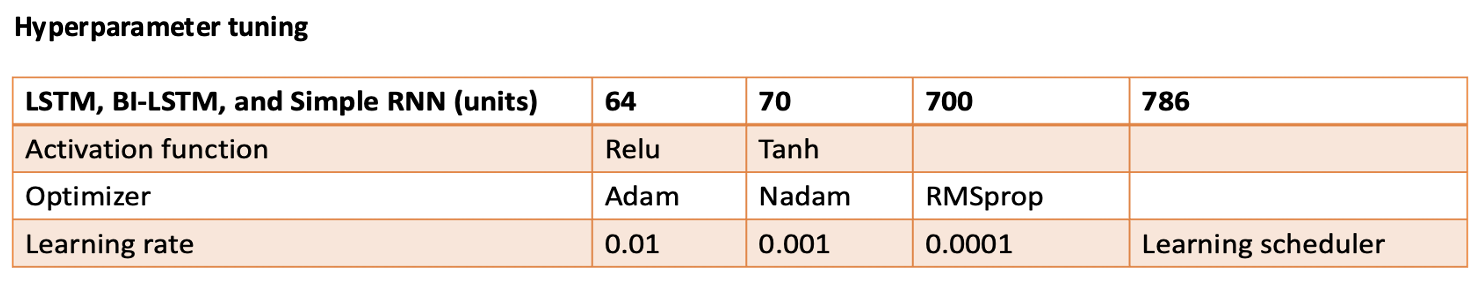

In [173]:
# exponential_decay_fn
import math 
def lr_exp_decay(epoch):
  initial_lr = 0.001
  drop_rate = 0.01
  epochs_drop = 5
  return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))


In [31]:
sequence_input = Input(shape=(max_length,))
x = layers.Embedding(len(word_index), 64, input_length=max_length, 
                    embeddings_regularizer=keras.regularizers.l2(.001))(sequence_input)
x = LSTM(64,activation= 'tanh', dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(x) 
x = Conv1D(64, 5, activation='tanh')(x)
x = MaxPooling1D()(x)

x = Flatten()(x)
x = Dense(70, activation='tanh')(x)
preds = Dense(3, activation='softmax')(x)

model2 = Model(sequence_input, preds)


checkpoint_cb = keras.callbacks.ModelCheckpoint( "Model" + "_{epoch:02d}.hdf5", save_best_only=False) # By default saves the model at the end of each Epoch
checkpoint = keras.callbacks.ModelCheckpoint( "Model_2.h5" , monitor='val_acc', verbose=1, save_best_only=False)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

model2.summary()

# model2.compile(optimizer = "rmsprop",
#               loss='categorical_crossentropy',
#               # optimizer='rmsprop',
#               metrics=['accuracy'])

# # happy learning!
# history = model2.fit(X_train_padded,
#            y_train, 
#            validation_split = 0.20,
#            callbacks = [checkpoint, checkpoint_cb,
#                         tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)],
#            epochs=5)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 64)           414528    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                             

In [321]:
# Model_output = pd.DataFrame(history.history)
# Model_output
# plt.figure
# sns.lineplot(data=Model_output, x= Model_output.index , y="accuracy", label = "Train Accuracy").set(title='Epoch vs Accuracy')
# sns.lineplot(data=Model_output, x= Model_output.index, y="val_accuracy", label = "Validation Accuracy", palette=['y'])


In [20]:
# model.save("best_Model3.h5")

model = keras.models.load_model("Best_Model1.h5")


In [38]:
(model.evaluate(X_test_padded, y_test), model.evaluate(X_train_padded, y_train))

46/46 [==============================] - 2s 33ms/step - loss: 0.5130 - accuracy: 0.8296


([1.3169853687286377, 0.5950919985771179],
 [0.5130017399787903, 0.8295688033103943])

In [39]:
model.summary()

Model: "model_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_113 (InputLayer)      [(None, 100)]             0         
                                                                 
 embedding_98 (Embedding)    (None, 100, 64)           414528    
                                                                 
 lstm_161 (LSTM)             (None, 100, 64)           33024     
                                                                 
 conv1d_114 (Conv1D)         (None, 96, 64)            20544     
                                                                 
 max_pooling1d_112 (MaxPooli  (None, 48, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_141 (Flatten)       (None, 3072)              0         
                                                         

In [40]:
# model = keras.models.load_model("Model_04.hdf5")
# model.save("Model_.h5")

In [41]:
# model = keras.models.load_model("best_Model2.h5")
print(model.evaluate(X_test_padded, y_test))
print("Train + validation", model.evaluate(X_train_padded, y_train))
print("Train Accuracy:", 84)

6/6 [==============================] - 0s 33ms/step - loss: 1.3170 - accuracy: 0.5951
[1.3169853687286377, 0.5950919985771179]
46/46 [==============================] - 2s 34ms/step - loss: 0.5130 - accuracy: 0.8296
Train + validation [0.5130017399787903, 0.8295688033103943]
Train Accuracy: 84


In [42]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)
print('Model accuracy: ', round(test_acc*100, 0))
predictions = model.predict(X_test_padded)

6/6 - 0s - loss: 1.3170 - accuracy: 0.5951 - 206ms/epoch - 34ms/step
Model accuracy:  60.0


In [43]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


Text(0.5, 114.0, 'True Class')

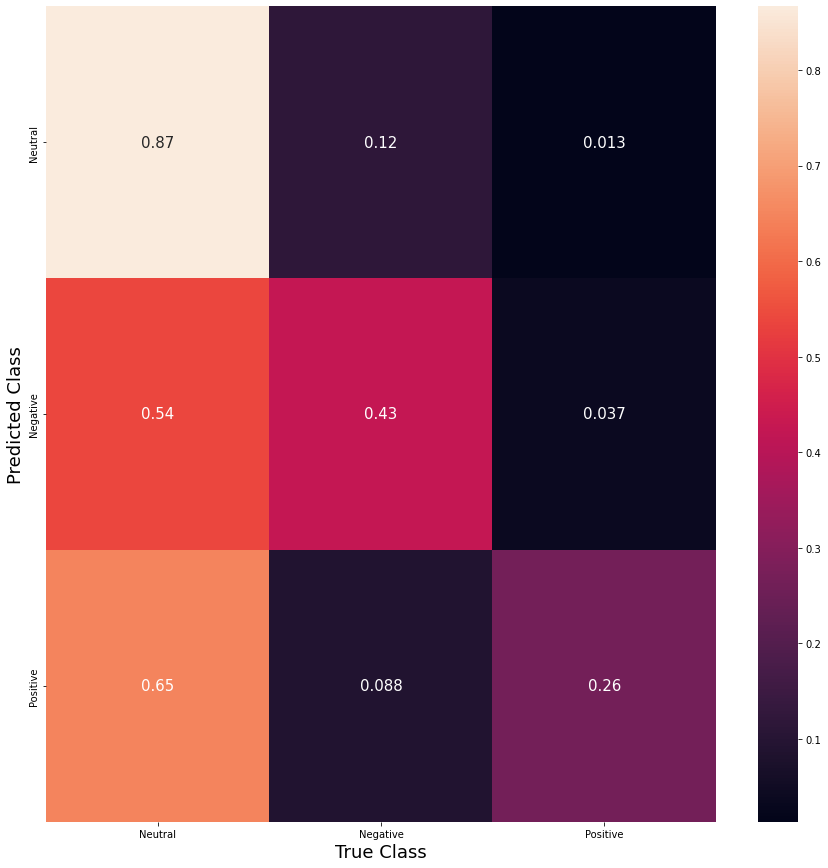

In [44]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.ylabel("Predicted Class", fontsize=18)
plt.xlabel("True Class", fontsize=18)

In [65]:
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_score, recall_score

print("F_1Score", f1_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average=None)) 
print("Precision", precision_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average=None)) 
print("Recall", recall_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average=None)) 


F1Score [0.68062827 0.51685393 0.39130435]
Precision [0.56034483 0.65714286 0.75      ]
Recall [0.86666667 0.42592593 0.26470588]


Another averaging method, macro, take the average of each class’s F-1 score:

In [62]:
print("F1Score:", f1_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="macro")) 
print("Precision:", precision_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="macro")) 
print("Recall:", recall_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="macro")) 


F1Score 0.5295955175538886
Precision 0.6558292282430213
Recall 0.5190994916485113


micro calculates positive and negative values globally:

In [63]:
print("F1Score:", f1_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="micro")) 
print("Precision:", precision_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="micro")) 
print("Recall:", recall_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="micro")) 


F1Score 0.5950920245398773
Precision 0.5950920245398773
Recall 0.5950920245398773


The third parameter we’ll consider in this tutorial is weighted. The class F-1 scores are averaged by using the number of instances in a class as weights::

In [64]:
print("F1Score:", f1_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="weighted")) 
print("Precision:", precision_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="weighted")) 
print("Recall:", recall_score(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1), average="weighted")) 


F1Score 0.5660219668986852
Precision 0.6319728610716553
Recall 0.5950920245398773
